<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Ponto de partida (EDA) </h1> 
</div>

![](img/header.png?t=2021-04-09-00-57-05)

Para essa competição foi disponibilizado diversos arquivos de previsões, os quais devemos combinar para montar os datasets de treino e teste. A métrica de avaliação é <b>logloss</b> que tem a seguinte formula: 

![](img/lloss.jpg)
    
    
O uso do logaritmo fornece punições extremas por estar confiante e errado. Na pior das hipóteses, uma previsão de que algo é verdadeiro quando na verdade é falso adicionará uma quantidade infinita à sua pontuação de erro. Para evitar isso, as previsões são limitadas dos extremos por um valor pequeno.  

---

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> OBJETIVO </h1>    
</div>

Neste notebook vamos fazer uma análise (EDA) para conhencer os dados e estabelecer uma linha de base, mostrarei as etapas iniciais de uma competição do Kaggle - desde a compreensão do conjunto de dados até a preparação dos dados para serem usados em um modelo machine learning. 


---

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [ ]:
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    !pip install --q catboost
    !pip install --q colorama
    #!pip install --q optbinning
    #!pip install --q catboost
    #!pip install --q pandas-profiling
    #!pip install --q pycaret
        
    from google.colab import drive
    drive.mount('/content/drive')

     |████████████████████████████████| 72 kB 901 kB/s 
     |████████████████████████████████| 569 kB 4.5 MB/s 
     |████████████████████████████████| 76.6 MB 123.8 MB/s 
Mounted at /content/drive


## 1.2. Bibliotecas 

In [ ]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
#import datetime
import multiprocessing
import glob

In [ ]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import scipy.stats       as stats
import plotly.express    as px
import xgboost           as xgb
import lightgbm          as lgb

In [ ]:
from matplotlib.axes._axes      import _log as matplotlib_axes_logger
from sklearn.model_selection    import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing      import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer
from sklearn.metrics            import roc_auc_score, f1_score, log_loss, roc_curve, auc
from sklearn.metrics            import classification_report, confusion_matrix, precision_score

In [ ]:
from tqdm.notebook             import tqdm, trange
from datetime                  import datetime
from colorama                  import Fore, Back, Style
from sklearn.calibration       import CalibrationDisplay
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline          import Pipeline, make_pipeline, FeatureUnion
from sklearn.decomposition     import PCA

In [ ]:
from sklearn.linear_model   import LogisticRegression
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.ensemble       import ExtraTreesClassifier

from sklearn.neighbors      import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import AdaBoostClassifier
from sklearn.ensemble       import HistGradientBoostingClassifier
import glob, pickle, scipy.optimize, scipy.special

---

## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [ ]:
class Utility():
        
    def __init__(self):
        self.name_ =''
       
    def jupyter_setting():
    
        %matplotlib inline

        #os.environ["WANDB_SILENT"] = "true" 
        #plt.style.use('bmh') 
        #plt.rcParams['figure.figsize'] = [20,15]
        #plt.rcParams['font.size']      = 13

        matplotlib_axes_logger.setLevel('ERROR')

        pd.options.display.max_columns = None
        #pd.set_option('display.expand_frame_repr', False)

        warnings.filterwarnings(action='ignore')
        warnings.simplefilter('ignore')
        warnings.filterwarnings('ignore')
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
        warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)
        warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

        pd.options.mode.chained_assignment = None 
        pd.set_option('display.max_rows', 200)
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.max_colwidth', 200)

        icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
        #sns.palplot(sns.color_palette(icecream))

        colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
              "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
              "lightskyblue", "sandybrown", "yellowgreen", "indianred",
              "lightsteelblue", "mediumorchid", "deepskyblue"]

        # Colors
        dark_red   = "#b20710"
        black      = "#221f1f"
        green      = "#009473"
        myred      = '#CD5C5C'
        myblue     = '#6495ED'
        mygreen    = '#90EE90'    
        color_cols = [myred, myblue,mygreen]

        return icecream, colors, color_cols

    def missing_zero_values_table(self, df):
        
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()
    
    def reduce_memory_usage(self, df, verbose=True):
    
        numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
        start_mem = df.memory_usage().sum() / 1024 ** 2

        for col in df.columns:

            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == "int":
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print(
                "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
                )
            )

        return df
    
    def graf_label(self, ax, total):

         for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            width, height = i.get_width() -.2 , i.get_height()

            x, y  = i.get_xy()  
            color = 'white'
            alt   = .5
            soma  = 0 

            if height < 70:
                color = 'black'
                alt   = 1
                soma  = 10

            ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                        (i.get_x()+.55*width, 
                         i.get_y()+soma + alt*height),
                         color   = color,
                         weight = 'bold',
                         size   = 14)
            
    def graf_bar(self, df, col, title, xlabel, ylabel, tol = 0):
    
        #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
        ax     = df    
        colors = col

        if tol == 0: 
            total  = sum(ax)
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           color   = colors, 
                           grid    = False)
        else:
            total  = tol     
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           figsize = (10,6),
                           color   = colors,
                           grid    = False)

        title   = title #+ ' \n'
        xlabel  = '\n ' + xlabel 
        ylabel  = ylabel + ' \n'

        ax.set_title(title  , fontsize=22)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)    

        min = [0,23000000]
        #ax.set_ylim(min)
        self.graf_label(ax, total)

    def correlation(self, df_, threshold_):
        col_corr    = set()  
        corr_matrix = df_.corr()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold_: 
                    colname = corr_matrix.columns[i]  
                    col_corr.add(colname)
                    
        return col_corr

    def __graf_fature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                         print_graf_=True, mask_=True, title_='', method_='pearson'):
        
        msg_title = '\n Correlação das variável {} -{} \n'.format(title_, 'method_')
        
        df = df_.copy().corr(method =method_).round(5)
        
        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_
            
            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}                              
                            )

            ax.set_title(msg_title, fontsize=17)
            
            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal", style = 'whitegrid', palette= 'pastel')

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right", style = 'whitegrid', palette= 'pastel')
            
            
            
            plt.show();
            
            
            
        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
        
        #sns.set(style="darkgrid")
        plt.show();
                        
    def describe(self, df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']

        return m

    def graf_outlier(self, df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                   (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

    def diff(self, t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
    
    def free_gpu_cache(self):

        # https://www.kaggle.com/getting-started/140636
        #print("Initial GPU Usage")
        #gpu_usage()                             

        #cuda.select_device(0)
        #cuda.close()
        #cuda.select_device(0)   

        gc.collect()
        torch.cuda.empty_cache()

    def graf_eval(self):

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#

            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))


            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();

    def linear_fit_slope(self, y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope

    def linear_fit_intercept(self, y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept

    def cromer_v(self, x, y):
        cm       = pd.crosstab(x, y).to_numpy()        
        n        = cm.sum()
        r, k     = cm.shape
        chi2     = stats.chi2_contingency(cm)[0]
        chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
        kcorr    = k - (k-1) **2/(n-1)
        rcorr    = r - (r-1) **2/(n-1)    
        v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
        return v  

    def generate_category_table(self, data):

        cols    = data.select_dtypes(include='object').columns
        dataset = pd.DataFrame()

        for i in cols:
            corr = []
            for x in cols: 
                corr.append(self.cromer_v(data[i],data[x]))

            aux     = pd.DataFrame({i:corr})
            dataset = pd.concat([dataset, aux], axis=1) 

        return dataset.set_index(dataset.columns)
            
    def graf_feature_corr(self, df_, annot_=False, threshold_=.8, print_var_=False, 
                          print_graf_=True, mask_=True, title_='', method_='pearson'):

        df = df_.corr(method=method_).round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            sns.set(style="whitegrid", palette="pastel") 
            
            # Making a plot
            ax = sns.heatmap(df, annot = annot_, 
                             mask      = mask, 
                             cmap      = "RdBu", 
                             fmt       = ".2f",
                             annot_kws = {"weight": "bold", "fontsize":10}
                            )
            
            ax.set_title("\n Correlação das variável {} - {} \n".format(title_, method_.upper()), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")
            
            sns.set(style="darkgrid")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                
        return self.correlation(df_, threshold_)

    def plot_roc_curve(self, fpr, tpr, label=None):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "r-", label=label)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for FLAI 08')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.grid(True)

    def feature_engineering(self, df_):

        var_f27 = ''
        for col in df_['f_27']: 
            var_f27 +=col

        var_f27 = list(set(var_f27))
        var_f27.sort()

        df_["fe_f_27_unique"] = df_["f_27"].apply(lambda x: len(set(x)))

        for letra in var_f27:             
            df_['fe_' + letra.lower() + '_count'] = df2_train["f_27"].str.count(letra)

        return df_ 

    def identifies_outliers(self, df):

        cols_num = df.select_dtypes(np.number).columns

        for col in cols_num: 
            if col != 'unnamed':            
                Q1  = df[col].quantile(0.25)
                Q3  = df[col].quantile(0.75)
                IQR = Q3-Q1
                lowqe_bound=Q1 - 1.5 * IQR
                upper_bound=Q3 + 1.5 * IQR

                df['outliers_'+ col] = 0
                df['outliers_'+ col][(df[col]<=lowqe_bound)|(df[col]>=upper_bound)] = 1    

                df[col] = np.where(df[col] > df[col].quantile(0.95),
                                                df[col].median(),
                                                df[col])

    def evaluation(self, y_, predictions_, smape_base_=100):
        from sklearn import metrics
        mae   = metrics.mean_absolute_error(y_, predictions_)
        mse   = metrics.mean_squared_error(y_, predictions_)
        rmse  = metrics.mean_squared_error(y_, predictions_, squared=False) 
        mape  = metrics.mean_absolute_percentage_error(y_, predictions_)
        smape = self.smape(y_, predictions_)
        r2    = metrics.r2_score(y_, predictions_)    
        return rmse, mae, mse, mape, r2, smape
    
    def feature_statistic(self, df, feature_float, feature_cat=None):
        df['fe_mean']        = df[feature_float].mean(axis=1)   
        df['fe_std']         = df[feature_float].std(axis=1)   
        df['fe_median']      = df[feature_float].median(axis=1)   
        df['fe_var']         = df[feature_float].var(axis=1) 
        df['fe_min']         = df[feature_float].min(axis=1)   
        df['fe_max']         = df[feature_float].max(axis=1)   
        df['fe_skew']        = df[feature_float].skew(axis=1)   
        df['fe_quantile_25'] = df[feature_float].quantile(q=.25, axis=1)
        df['fe_quantile_50'] = df[feature_float].quantile(q=.5, axis=1)
        df['fe_quantile_75'] = df[feature_float].quantile(q=.75, axis=1)
        
        if feature_cat is not None:
            df['fe_dammy_count'] = df[feature_cat].sum(axis=1)   
        
        return df
    
    def gridSearchCV(self, model_, params_, X_train_, y_train_):
        """
        @param    model: sklearn estimator
        @param    params (dict): Dictionary of possible parameters

        @return   cv_results (DataFrame)
        """
        model_cv = GridSearchCV(model_, param_grid=params_, scoring='roc_auc', cv=5)
        model_cv.fit(X_train_, y_train_)
        cv_results = pd.DataFrame(model_cv.cv_results_)[['params', 'mean_test_score']]

        return cv_results
    
    def evaluate(self, model,X_train_, y_train_, X_test_, plotROC=False):

        model.fit(X_train_, y_train_)
        probs = model.predict_proba(X_train_)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(y_train_, preds)
        roc_auc = auc(fpr, tpr)
        print(f'AUC: {roc_auc:.4f}')

        rocDf = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':threshold})
        rocDf['tpr - fpr'] = rocDf.tpr - rocDf.fpr
        optimalThreshold = rocDf.threshold[rocDf['tpr - fpr'].idxmax()]

        y_pred = np.where(preds >= optimalThreshold, 1, 0)

        # Plot ROC AUC
        if plotROC:
            plt.title('Receiver Operating Characteristic')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()    

    def iqr_outliers(self, df,ft):

        q1  = df[ft].quantile(0.25)
        q3  = df[ft].quantile(0.75)
        iqr = q3-q1
        c   = 0 

        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr

        for i in range(len(df[ft])):
            if df[ft][i] > Upper_tail or df[ft][i] < Lower_tail:
                c+=1
        return c
    
    def outlier_create_feature_check(self, df_tr_, df_ts_, cols_=[], qt_inferior_=.25, qt_superior_=.75, 
                                     flg_ts_=True, input_limete_=False, verbose_=True):
    
        col_oltlier         = 'fe_outlier'
        df_tr_[col_oltlier] = 0 
        df_ts_[col_oltlier] = 0 

        for c in cols_:

            percentil25 = df_tr_[c].quantile(qt_inferior_)
            percentil75 = df_tr_[c].quantile(qt_superior_)

            iqr= percentil75 - percentil25 

            limite_inferior = percentil25 - 1.5 * iqr
            limite_superior = percentil75 + 1.5 * iqr

            df_tr_[col_oltlier][df_tr_[c]>limite_superior] = -1
            df_tr_[col_oltlier][df_tr_[c]<limite_inferior] = -1

            if input_limete_:
                df_tr_[c][df_tr_[c]>limite_superior] = limite_superior
                df_tr_[c][df_tr_[c]<limite_inferior] = limite_inferior

            if flg_ts_:
                df_ts_[col_oltlier][df_ts_[c]>limite_superior] = -1
                df_ts_[col_oltlier][df_ts_[c]<limite_inferior] = -1
                
                if input_limete_:
                    df_ts_[c][df_ts_[c]>limite_superior] = limite_superior
                    df_ts_[c][df_ts_[c]<limite_inferior] = limite_inferior

            if verbose_:
                print('Com a variável {}'.format(c))
                print(df_tr_[col_oltlier].value_counts())
                print()

        return df_tr_, df_ts_
        
    def calibrated_classifier_graf_model(self, mdl_list_, X_, y_, seed_=12359, figsize_=(10, 10), verbose_=False): 

        fig = plt.figure(1, figsize=figsize_)
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        
        if verbose_: ax2 = plt.subplot2grid((3, 1), (2, 0))

        ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")

        for name, mdl1 in mdl_list_:  
            model_pipeline  = Pipeline(steps=[
                ('preprocessor', preprocessor_1),
                #('sampler_over', over), 
                #('sampler_under', under),    
                ('variancethreshold', VarianceThreshold(threshold=0.1)),    
                ('selectpercentile', SelectPercentile(f_classif, percentile=90)), 
                ('model', mdl1)
                ])

            X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.5, random_state=seed_)

            model_calibrated = CalibratedClassifierCV(model_pipeline, method='isotonic', cv=2) 
            # method='isotonic' sigmoid

            model_calibrated.fit(X_train, y_train)

            if hasattr(model_calibrated, "predict_proba"):
                prob_pos = model_calibrated.predict_proba(X_val)[:, 1]
            else:  
                prob_pos = model_calibrated.decision_function(X_val)
                prob_pos = (prob_pos-prob_pos.min()) / (prob_pos.max()-prob_pos.min())

            score = brier_score_loss(y_val, prob_pos, pos_label=y_val.max())

            frac_of_pos, mean_pred_value = calibration_curve(y_val, prob_pos, n_bins=15, normalize=True)      

            ax1.plot(mean_pred_value, frac_of_pos, "s-", label="%s (%1.3f)" % (name, score))

            ax1.set_ylabel('Fração de positivos')
            ax1.set_ylim([-0.05, 1.05])
            ax1.legend(loc='upper left' )
            ax1.set_title('\nGráficos de calibração (curva de confiabilidade)\n', fontsize=18)

            if verbose_: 
                ax2.hist(prob_pos, range=(0, 1), bins=100, label=name, histtype="step", lw=2)    
                ax2.set_xlabel('Valor médio previsto')
                ax2.set_ylabel('Quantidade')
                ax2.legend(loc="upper left", ncol=1)

                plt.tight_layout()

                msg = 'AUC: {:2.5f} - F1: {:2.5f} - Perda: {:2.3f} -> {}'
                auc = roc_auc_score(y_val, prob_pos)
                f1  = f1_score(y_val, (prob_pos>.5).astype(int))
                print(msg.format(auc,f1, score, name))

        plt.show()

    def describe(df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
        
        return m
        
    def smape(self, a, f):
        return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

    def smape_(self, y_true, y_pred, base_=100.):
        denominator          = (np.abs(y_true)+np.abs(y_pred))/base_
        diff                 = np.abs(y_true-y_pred)/denominator
        diff[denominator==0] = 0.0
        return np.nanmean(diff)
    
    def smape_loss(y_true, y_pred):
        """SMAPE Loss"""
        return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200
    
    def calc_erro(y, y_pred, outros=True, ruturn_score=False):
        erro   = smape(y, y_pred)    
        
        
        if outros:        
            rmse = metrics.mean_squared_error(y, y_pred, squared=False)
            mape = metrics.mean_absolute_percentage_error(y, y_pred)
            mae  = metrics.mean_absolute_error(y, y_pred)
            
            print('RMSE : {:2.5f}'.format(rmse))
            print('MAE  : {:2.5f}'.format(mae))
            print('MAPE : {:2.5f}'.format(mape))
            
            
        if ruturn_score: 
            return erro
        else: 
            print('SMAPE: {:2.5f}'.format(erro))
            
    def graf_outlier(df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 
                    
    def graf_eval():

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#
            
            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))
                        
            
            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();
        
    def linear_fit_slope(y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope
        
    def linear_fit_intercept(y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept
    
    def create_fold(self, path_): 

        paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
                 'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
                 'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
                 'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
                 'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

        for p in paths:
            try:
                os.mkdir(path_+p)       
            except:
                #print('Erro ao criar pasta: {} '.format(path+p))
                pass 
        
utility = Utility()

In [ ]:
def read_data(path: str, analyze:bool=True) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test  = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    if analyze:
        print("=== Shape of Data ===")
        print(f" train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
        print(f" test data : Rows={test.shape[0]}, Columns={test.shape[1]}")

        print("\n=== Train Data: First 5 Rows ===\n")
        display(train.head())
        print("\n=== Train Column Names ===\n")
        display(train.columns)
        print("\n=== Features/Explanatory Variables ===\n")
        eval_features(train)
        print("\n === Skewness ===\n")
        check_skew(train)
    return train, test, submission_df

In [ ]:
icecream, colors, color_cols = Utility.jupyter_setting()
n_threads = multiprocessing.cpu_count()

## 1.4. Dataset

### 1.4.1. Descrição de dados

Os dados dessa competição representam o resultados de previsões de modelos, que foram criadas em 5000 arquivos de submissões, cada arquivos tem 40.000 previsões. Temos que fazer a combinação desses arquivos para montar os dataset de treino e teste. 


### 1.4.2. Arquivos 
- <b>train.csv</b>: incluem apenas a variável alvo;
- <b>submission_files</b>: pasta com os arquivos de previões;
- <b>sample_submission.csv</b>: arquivo de envio com as previsões.

### 1.4.3. Estrutura de pasta
A finalidade é criar um estrutura de pasta para armazenar os artefatos criados no processo de análise e modelagem.

In [ ]:
path        =  '/content/drive/MyDrive/kaggle/Tabular Playground Series/2022/10 - Novembro/' if COLAB else ''      
path_data   = 'Data/'  
path_automl = 'automl/'
target      = 'label'

utility.create_fold(path)

### 1.4.4. Carrega dados

In [ ]:
df1_train     = pd.read_csv(path + path_data + "train_labels.csv")
df_submission = pd.read_csv(path + path_data + "sample_submission.csv")

display(df1_train.head())
print(f" train data: Rows={df1_train.shape[0]}, Columns={df1_train.shape[1]}")
display(df_submission.head())

,id,label
0,0,0
1,1,1
2,2,1
3,3,1
4,4,0


 train data: Rows=20000, Columns=2


,id,pred
0,20000,0.640707
1,20001,0.636904
2,20002,0.392496
3,20003,0.588658
4,20004,0.783603


In [ ]:
df_pred       = pd.DataFrame(np.zeros(40000), columns=['id'])
df_pred['id'] = df_pred.index

file_list = sorted(glob.glob(os.path.join(path + path_data, "submission_files/*.csv")))

In [ ]:
#df_pred = jb.load(path + path_data + 'pkl/df_pred.pkl.z')

In [ ]:
%%time 

for idx, file in enumerate(tqdm(file_list)):
    df_pred[f'pred_{idx}'] = pd.read_csv(file)["pred"].to_numpy()  
    
df_pred.set_index('id', inplace=True)
jb.dump(df_pred, path + path_data + 'pkl/df_pred.pkl.z')

df_pred.head()

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 1min 52s, sys: 5.33 s, total: 1min 57s
Wall time: 5min 15s


,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15,pred_16,pred_17,pred_18,pred_19,pred_20,pred_21,pred_22,pred_23,pred_24,pred_25,pred_26,pred_27,pred_28,pred_29,pred_30,pred_31,pred_32,pred_33,pred_34,pred_35,pred_36,pred_37,pred_38,pred_39,pred_40,pred_41,pred_42,pred_43,pred_44,pred_45,pred_46,pred_47,pred_48,pred_49,pred_50,pred_51,pred_52,pred_53,pred_54,pred_55,pred_56,pred_57,pred_58,pred_59,pred_60,pred_61,pred_62,pred_63,pred_64,pred_65,pred_66,pred_67,pred_68,pred_69,pred_70,pred_71,pred_72,pred_73,pred_74,pred_75,pred_76,pred_77,pred_78,pred_79,pred_80,pred_81,pred_82,pred_83,pred_84,pred_85,pred_86,pred_87,pred_88,pred_89,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99,pred_100,pred_101,pred_102,pred_103,pred_104,pred_105,pred_106,pred_107,pred_108,pred_109,pred_110,pred_111,pred_112,pred_113,pred_114,pred_115,pred_116,pred_117,pred_118,pred_119,pred_120,pred_121,pred_122,pred_123,pred_124,pred_125,pred_126,pred_127,pred_128,pred_129,pred_130,pred_131,pred_132,pred_133,pred_134,pred_135,pred_136,pred_137,pred_138,pred_139,pred_140,pred_141,pred_142,pred_143,pred_144,pred_145,pred_146,pred_147,pred_148,pred_149,pred_150,pred_151,pred_152,pred_153,pred_154,pred_155,pred_156,pred_157,pred_158,pred_159,pred_160,pred_161,pred_162,pred_163,pred_164,pred_165,pred_166,pred_167,pred_168,pred_169,pred_170,pred_171,pred_172,pred_173,pred_174,pred_175,pred_176,pred_177,pred_178,pred_179,pred_180,pred_181,pred_182,pred_183,pred_184,pred_185,pred_186,pred_187,pred_188,pred_189,pred_190,pred_191,pred_192,pred_193,pred_194,pred_195,pred_196,pred_197,pred_198,pred_199,pred_200,pred_201,pred_202,pred_203,pred_204,pred_205,pred_206,pred_207,pred_208,pred_209,pred_210,pred_211,pred_212,pred_213,pred_214,pred_215,pred_216,pred_217,pred_218,pred_219,pred_220,pred_221,pred_222,pred_223,pred_224,pred_225,pred_226,pred_227,pred_228,pred_229,pred_230,pred_231,pred_232,pred_233,pred_234,pred_235,pred_236,pred_237,pred_238,pred_239,pred_240,pred_241,pred_242,pred_243,pred_244,pred_245,pred_246,pred_247,pred_248,pred_249,...,pred_4750,pred_4751,pred_4752,pred_4753,pred_4754,pred_4755,pred_4756,pred_4757,pred_4758,pred_4759,pred_4760,pred_4761,pred_4762,pred_4763,pred_4764,pred_4765,pred_4766,pred_4767,pred_4768,pred_4769,pred_4770,pred_4771,pred_4772,pred_4773,pred_4774,pred_4775,pred_4776,pred_4777,pred_4778,pred_4779,pred_4780,pred_4781,pred_4782,pred_4783,pred_4784,pred_4785,pred_4786,pred_4787,pred_4788,pred_4789,pred_4790,pred_4791,pred_4792,pred_4793,pred_4794,pred_4795,pred_4796,pred_4797,pred_4798,pred_4799,pred_4800,pred_4801,pred_4802,pred_4803,pred_4804,pred_4805,pred_4806,pred_4807,pred_4808,pred_4809,pred_4810,pred_4811,pred_4812,pred_4813,pred_4814,pred_4815,pred_4816,pred_4817,pred_4818,pred_4819,pred_4820,pred_4821,pred_4822,pred_4823,pred_4824,pred_4825,pred_4826,pred_4827,pred_4828,pred_4829,pred_4830,pred_4831,pred_4832,pred_4833,pred_4834,pred_4835,pred_4836,pred_4837,pred_4838,pred_4839,pred_4840,pred_4841,pred_4842,pred_4843,pred_4844,pred_4845,pred_4846,pred_4847,pred_4848,pred_4849,pred_4850,pred_4851,pred_4852,pred_4853,pred_4854,pred_4855,pred_4856,pred_4857,pred_4858,pred_4859,pred_4860,pred_4861,pred_4862,pred_4863,pred_4864,pred_4865,pred_4866,pred_4867,pred_4868,pred_4869,pred_4870,pred_4871,pred_4872,pred_4873,pred_4874,pred_4875,pred_4876,pred_4877,pred_4878,pred_4879,pred_4880,pred_4881,pred_4882,pred_4883,pred_4884,pred_4885,pred_4886,pred_4887,pred_4888,pred_4889,pred_4890,pred_4891,pred_4892,pred_4893,pred_4894,pred_4895,pred_4896,pred_4897,pred_4898,pred_4899,pred_4900,pred_4901,pred_4902,pred_4903,pred_4904,pred_4905,pred_4906,pred_4907,pred_4908,pred_4909,pred_4910,pred_4911,pred_4912,pred_4913,pred_4914,pred_4915,pred_4916,pred_4917,pred_4918,pred_4919,pred_4920,pred_4921,pred_4922,pred_4923,pred_4924,pred_4925,pred_4926,pred_4927,pred_4928,pred_4929,pred_4930,pred_4931,pred_4932,pred_4933,pred_4934,pred_

---

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. Análise Exploratória de Dados (EDA) </h1>    
</div>

Antes de trabalhar com qualquer tipo de dados é importante entendê-los. Um passo crucial para esse objetivo é a Análise Exploratória de Dados (EDA): uma combinação de visualizações e análise estatística (uni, bi e multivariada) que nos ajude a entender melhor os dados com os quais estamos trabalhando e obter insights sobre seus relacionamentos.

In [ ]:
df2_train = df_pred[:df1_train.shape[0]].copy() 
df2_test  = df_pred[df1_train.shape[0]:].reset_index(drop=True)

df2_train[target] = df1_train[target]

## 2.1. Dimensão do DataSet

In [ ]:
print('TREINO')
print('Numero de linhas : {}'.format(df2_train.shape[0]))
print('Numero de colunas: {}'.format(df2_train.shape[1]), end='\n\n')

print('TESTE')
print('Numero de linhas : {}'.format(df2_test.shape[0]))
print('Numero de colunas: {}'.format(df2_test.shape[1]), end='\n\n')

TREINO
Numero de linhas : 20000
Numero de colunas: 5001

TESTE
Numero de linhas : 20000
Numero de colunas: 5000



## 2.2. Tipo de dados

In [ ]:
df2_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Columns: 5001 entries, pred_0 to label
dtypes: float64(5000), int64(1)
memory usage: 763.2 MB


## 2.3. Identificar NA

In [ ]:
missing = utility.missing_zero_values_table(df2_train)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 5001 colunas e 20000 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


In [ ]:
missing = utility.missing_zero_values_table(df2_test)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 5000 colunas e 20000 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 
Não temos valores ausentes. 

    
</div>

## 2.4. Outliers 

In [ ]:
print('Valores mínimos e máximos') 
for _ in [('Treino', df2_train), ('Teste ', df2_test)]: 
    msg = '{}: {} / {} => ({}/{})' 
    _min, _max      = _[1].values.min(),_[1].values.max()
    _abaixo, _acima = (_[1].values<0).sum(), (_[1].values>1).sum() 
    print(msg.format(_[0], _min, _max, _abaixo, _acima ))
        
del _min, _max, _abaixo, _acima

Valores mínimos e máximos
Treino: -0.336521 / 1.356611 => (958/7996)
Teste : -0.376186 / 1.311234 => (1009/7596)


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 
Observamos que temos valores negativo e acima de 1, isso é um indicativo que que devemos fazer a exclusão desses valores discrepantes, por ser tratar de probabilidade devem ficar entre 0 e 1. Com a exclusão desses valores discrepantes vamos ter um redução no número de variáveis. 

    
</div>

## 2.5. Dados duplicados

In [ ]:
_ = pd.DataFrame(df2_train.sum()).reset_index().set_index('index')
_.columns = ['values']
_[_['values'].duplicated()]

,values
index,


---

## 2.6. Nomes de arquivos e perda de log

In [ ]:
_start        = len(file_list[0])-16 
log_loss_list = []
y             = df2_train[target]

print('name                          log loss')
for sub in range(5):
    name_loss = float(file_list[sub][_start:-4])
    print(file_list[sub][_start:], name_loss , log_loss(y, df2_train.values[:,sub]))

for sub in range(df2_train.shape[1]-1):    
    name_loss = float(file_list[sub][_start:-4])
    log_loss_list.append(name_loss)

name                          log loss
0.6222863195.csv 0.6222863195 0.6222863195129075
0.6223807245.csv 0.6223807245 0.6223807245068153
0.6225426578.csv 0.6225426578 0.622542657774157
0.6247722291.csv 0.6247722291 0.6247722290993437
0.6253455681.csv 0.6253455681 0.6253455680841075


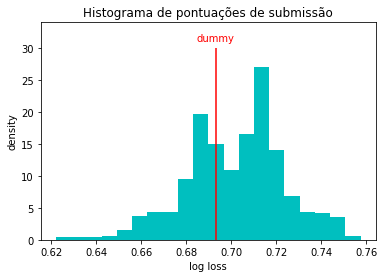

In [ ]:
plt.hist(log_loss_list, bins=20, density=True, color='c')
plt.vlines([log_loss(y, np.full(len(y), 0.5))], 0, 30, color='r')
plt.text(0.693, 31, 'dummy', color='r', ha='center')
plt.title('Histograma de pontuações de submissão')
plt.xlabel('log loss')
plt.ylabel('density')
plt.ylim(0, 34)
plt.show()

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 
O histograma das 5000 pontuações mostram que todos os modelos apresentam log loss entre 0,622 e 0,758, podemos notar que essas pontuações são bastante fracas? Um modelo fictício que prevê 0,5 o tempo todo tem uma perda logarítmica de 0,693 (linha vermelha no diagrama). Um modelo perfeito teria uma perda logarítmica de 0. <p><br>

<b>Insight:</b> <br>
Metade dos modelos de entrada são piores do que um classificador fictício! Devemos descartar essas colunas imediatamente? Não. Embora essas colunas tenham logloss alto, elas ainda contêm informações que podem ser valiosas para um conjunto.
    
<p><br>
    
<b>REFERÊNCIA:</b> [@AMBROSM](https://www.kaggle.com/code/ambrosm/tpsnov22-eda-which-makes-sense)

    
</div>


## 2.7. Distribuição

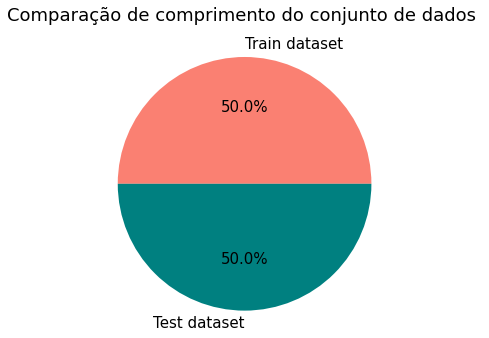

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

pie = ax.pie([len(df2_train), len(df2_test)],
             labels   = ["Train dataset", "Test dataset"],
             colors   = ["salmon", "teal"],
             textprops= {"fontsize": 15},
             autopct  = '%1.1f%%')

ax.axis("equal")
ax.set_title("Comparação de comprimento do conjunto de dados \n", fontsize=18)
fig.set_facecolor('white')
plt.show();

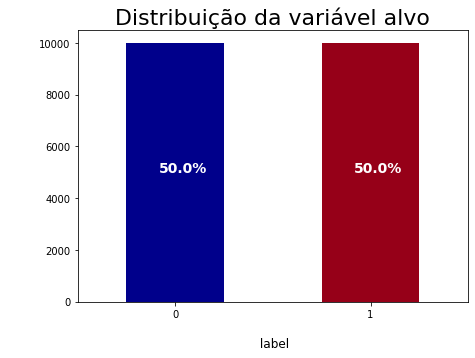

In [ ]:
plt.figure(figsize=(7,5))  
_ = df2_train.groupby([target])[target].count()
utility.graf_bar(_,icecream,'Distribuição da variável alvo',target, '');


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 
Os são equilibrados. 
    
</div>

### 2.7.1. Distribuição Train x Test

In [ ]:
feature_sample = df2_test.sample(27, axis='columns').columns.to_list()

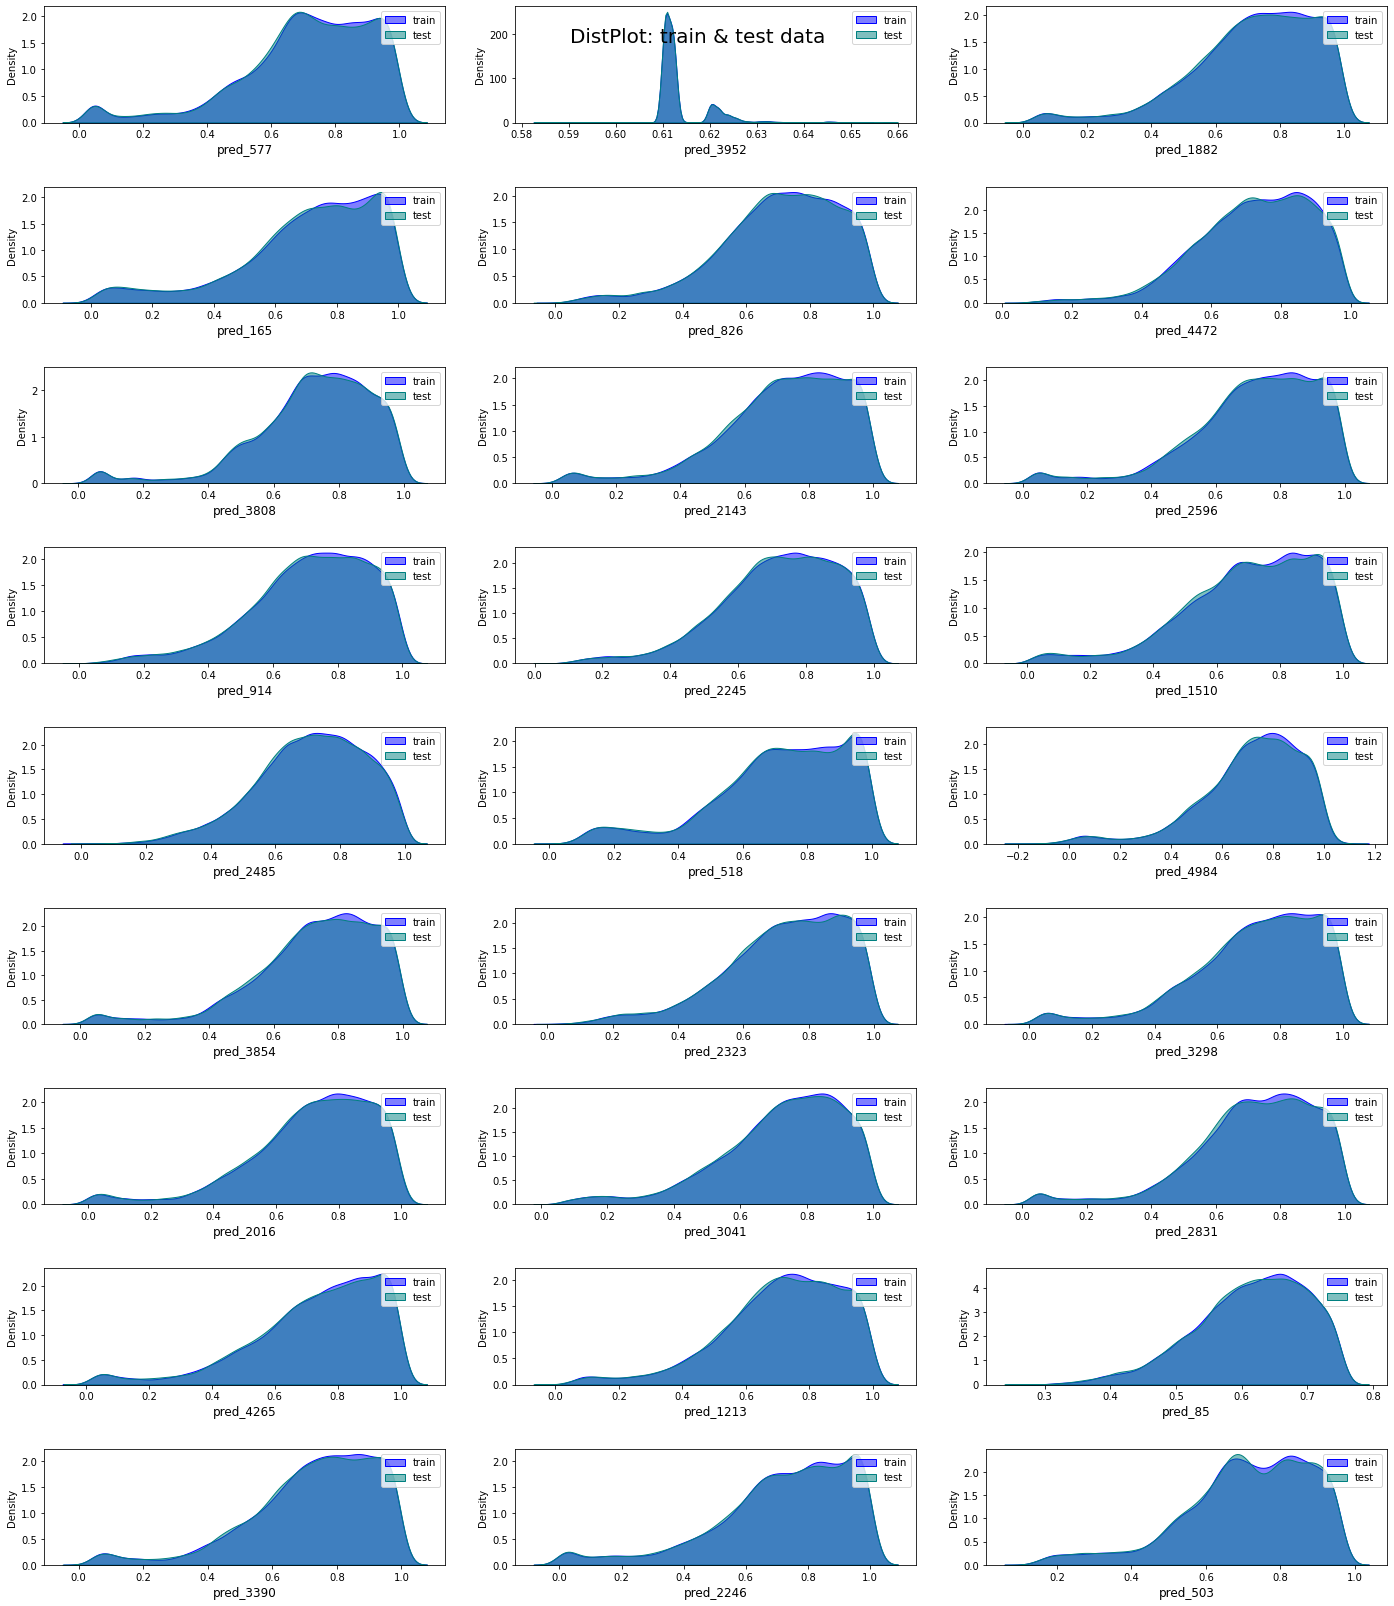

In [ ]:
lines   = int(len(feature_sample)/2)+1

plt.figure(figsize=(20,35))

for i,feature in enumerate(feature_sample):
    plt.subplot(lines,3,i+1)
    sns.kdeplot(df2_train[feature],color='blue', alpha=0.5, label='train', shade=True)
    sns.kdeplot(df2_test[feature] ,color='teal', alpha=0.5, label='test', shade=True)  
    plt.xlabel(feature, fontsize=12);
    plt.legend();

plt.suptitle('DistPlot: train & test data', fontsize=20)
plt.tight_layout(pad=3.0);

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 
Observamos que os dados de treino e teste seguem a mesma distribuição, porém a maioria dos dados da amostra apresentam assimetria longa, indicando um boa quantidade de outliers. Talvez uma normalização pode ajudar na assimetria.  
    
</div>

## 2.8. Correlação

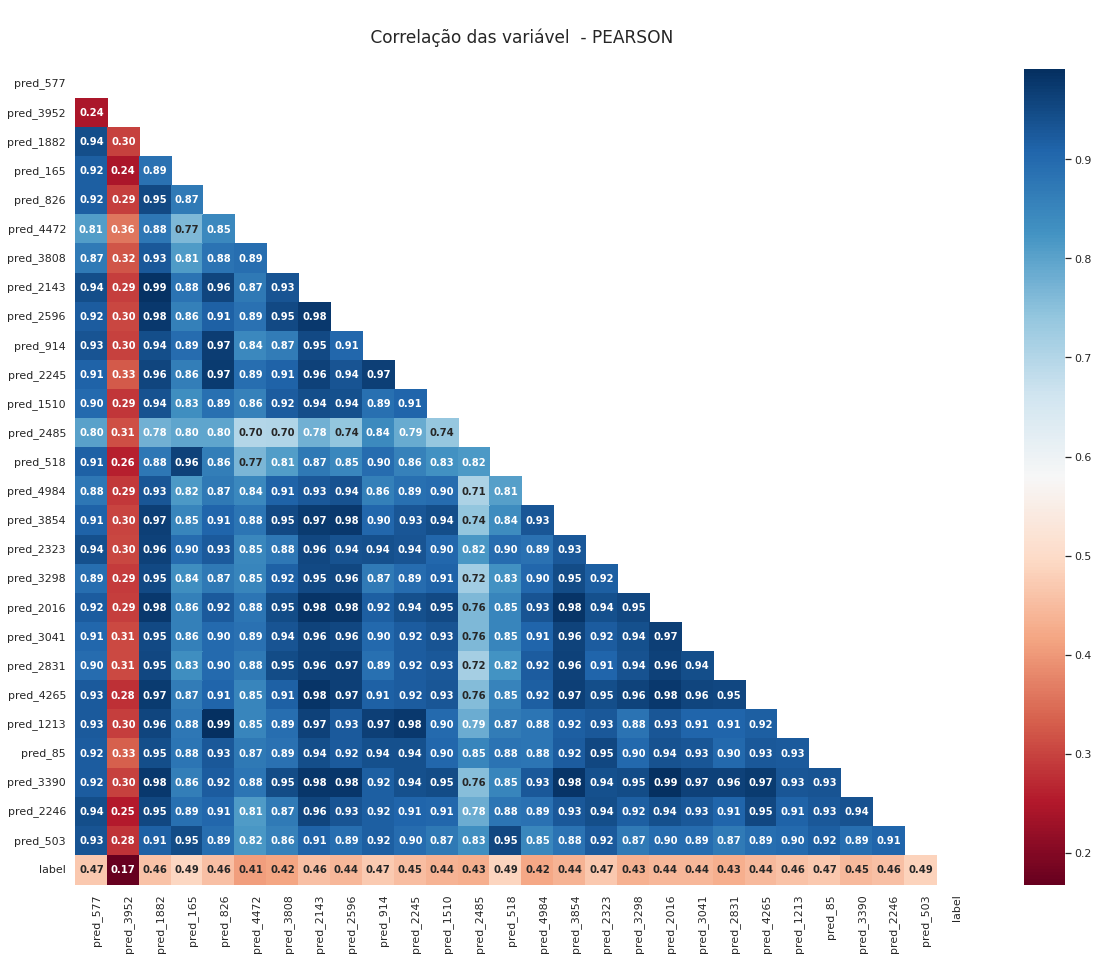

In [ ]:
plt.figure(figsize=(20,15))

feature_corr = \
    utility.graf_feature_corr(df_         = df2_train[feature_sample+[target]],                             
                              annot_      = True, 
                              threshold_  = .7, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = True, 
                             # method_     = 'spearman'
                              );

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 
Observamos que as variávies tem uma baixa correlação com a variável preditora, nesta amostra, outro ponto é alta correção entre as variáveis, isso é explicado por se tratarem de variáveis de previsões geradas por modelos. A remoção dessas variáveis autocorrelacionadas podem melhorar a perfomance de alguns modelos.      
    
</div>

---

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 3. MODELAGEM </h1>    
</div>

## 3.1. Train / teste

In [ ]:
seed = 12359

In [ ]:
def plot_oof_histogram(name, oof):
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
    ax1.hist(oof, range=(0, 1), bins=100, density=True, color='#ffd700')
    ax1.set_title(f"{name} ")
    ax1.set_facecolor('#0057b8') # blue
    
    CalibrationDisplay.from_predictions(y, oof, 
                                        n_bins=20,
                                        strategy='quantile', 
                                        ax=ax2, 
                                        color='#ffd700')
    
    ax2.set_title('Probability calibration')
    ax2.set_facecolor('#0057b8') # blue
    ax2.legend('', frameon=False)
    
    plt.show()

In [ ]:
%%time 

X      = df2_train.copy()
X_test = df2_test.copy()
#X      = X
#X_test = X_test
y      = df2_train[target]

# Inverta alguns dos subs para obter os melhores resultados de log_loss.
feature_inverted = ['pred_1818', 'pred_1953', 'pred_2009',
                    'pred_2126', 'pred_2575', 'pred_3851',
                    'pred_4213', 'pred_4708', 'pred_4882']

#X[feature_inverted]      = 1-X[feature_inverted].values
#X_test[feature_inverted] = 1-X_test[feature_inverted].values

X.drop(target, axis=1, inplace=True)

X.shape, X_test.shape

# https://www.kaggle.com/code/takanashihumbert/drop-4000-features-lb-0-51530

CPU times: user 574 ms, sys: 2.99 ms, total: 577 ms
Wall time: 569 ms


((20000, 5000), (20000, 5000))

In [ ]:
#X['pred_72_div_pred_121']      = X['pred_72']/X['pred_121']
#X_test['pred_72_div_pred_121'] = X_test['pred_72']/X_test['pred_121']

In [ ]:
# useful_cols = X.columns
# 
# for col in useful_cols:
#     if "div" in col:
#         continue
#     arr    = np.clip(X[col].values, 1e-7, 1 - 1e-7)
#     X[col] = np.log(arr/(1-arr))
# 
#     arr         = np.clip(X_test[col].values, 1e-7, 1 - 1e-7)
#     X_test[col] = np.log(arr/(1-arr))   

In [ ]:
# useful_subs = ['sub_65', 'sub_56', 'sub_62', 'sub_72', 'sub_121']
# for i in range(len(useful_subs) - 1):
#     for j in range(i+1, len(useful_subs)):
#         train_data[useful_subs[i] + '_minus_' + useful_subs[j]] = train_data[useful_subs[i]] - train_data[useful_subs[j]]
#         test_data[useful_subs[i] + '_minus_' + useful_subs[j]] = test_data[useful_subs[i]] - test_data[useful_subs[j]]
#         
#         train_data[useful_subs[i] + '_div_' + useful_subs[j]] = train_data[useful_subs[i]] / train_data[useful_subs[j]]
#         test_data[useful_subs[i] + '_div_' + useful_subs[j]] = test_data[useful_subs[i]] / test_data[useful_subs[j]]

## 3.2. Classificadore e pipeline

In [ ]:
params_xgb  = {
    'objective'            : 'binary:logistic', 
    'eval_metric'          : 'error',
    'n_estimators'         : 100,              
    #'max_depth'            : 4,
    #'learning_rate'        : .00001,              
    #'reg_lambda'           : 0.75, 
    #'colsample_bytree'     : 0.85,
    #'scale_pos_weight'     : scale_pos_weight,
    'random_state'         : seed}   

params_xgb  = {
    'objective'        : 'binary:logistic',
    'eval_metric'      : 'logloss',
    'learning_rate'    : 1e-2,
    'max_depth'        : 4,
    'subsample'        : 0.8,
    'sampling_method'  : 'uniform',
    'colsample_bytree' : 0.8,
    'colsample_bylevel': 0.8,
    'alpha'            : 0.9,
    'lambda'           : 1.2,
    'min_child_weight' : 1e-3,
    'max_leaves'       : 31,
    'n_jobs'           : -1,
    'seed'             : seed}

param_lgbm  = {
    'objective'         : 'binary',
    'metric'            :'binary_logloss',
    'colsample_bytree'  : 0.5139258065278501,
    'learning_rate'     : 0.02,
    'max_depth'         : 6,
    'min_child_samples' : 219,
    'min_child_weight'  : 1e-05,
    'n_estimators'      : 300,
    'num_leaves'        : 128,
    'reg_alpha'         : 1,
    'reg_lambda'        : 0,
    'subsample'         : 0.8116483602711031,         
    #'device': 'gpu',    
    'random_state'      : seed}

opt_parameters = {
    'colsample_bytree': 0.45066268483824545,
    'learning_rate': 0.02,
    'max_depth': 5,
    'min_child_samples': 285,
    'min_child_weight': 0.01,
    'n_estimators': 300,
    'num_leaves': 116,
    'reg_alpha': 1,
    'reg_lambda': 1,
    'subsample': 0.532329735064063, 
    'random_state'      : seed}

param_rf    = {
    'class_weight'      : 'balanced', 
    'n_estimators'      : 1000,
    'max_depth'         : 5, 
    #'max_features'     : 10, 
    'min_samples_split' : 50, 
    'min_samples_leaf'  : 10, 
    'bootstrap'         : True, 
    'random_state'      : seed}

param_ext   = {
    'n_estimators'     : 100, 
    'min_samples_leaf' :12, 
    'random_state'     : seed}

param_lr    = {
    'max_iter': 1000, 
    'C'       : 0.0001, 
    'penalty' : 'l2', 
    'solver'  : 'newton-cg'}

param_mlp   = {
    'learning_rate': 'adaptive', 
    'alpha'        : 0.5,
    'random_state' : seed}

param_hbc   = {
    'max_iter'            : 100,
    'validation_fraction' : 0.1,
    'random_state'        : seed}

if torch.cuda.is_available():           
    params_xgb.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})

pca    = PCA(n_components=50, random_state=seed)
scaler = QuantileTransformer(output_distribution='normal', random_state=seed)

model_lr   = LogisticRegression(**param_lr)
model_knn  = KNeighborsClassifier(n_neighbors=200)
model_mlp  = MLPClassifier(**param_mlp) 
model_xgb  = xgb.XGBClassifier(**params_xgb) 
model_ext  = ExtraTreesClassifier(**param_ext)
model_lgbm = lgb.LGBMClassifier(**param_lgbm)
model_rf   = RandomForestClassifier(**param_rf)
model_hbc  = HistGradientBoostingClassifier(**param_hbc)

preprocessor      = ('preprocessor', scaler)
variancethreshold = ('variancethreshold', VarianceThreshold(threshold=1.0e-03)) 
selectpercentile  = ('selectpercentile', SelectPercentile(f_classif, percentile=98))
selectKbest       = ('SelectKBest', SelectKBest(score_func=f_classif))

pipeline_lr   = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_lr)])
pipeline_knn  = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_knn)])
pipeline_mlp  = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_mlp)])
pipeline_xgb  = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_xgb)])
pipeline_ext  = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_ext)])
pipeline_lgbm = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_lgbm)])
pipeline_rf   = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_rf)])
pipeline_hbc  = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_hbc)])

## 3.3. Funções da modelagem

In [ ]:
def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):                    
                        os.remove(os.path.join(raiz, arquivo))

In [ ]:
def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_, y_pred_test_submission_, 
                    score_, seed_, level_='1', target_='target', cutoff_value_=.6, gera_submission_=True):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_)  + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_)  + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)  + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(y_pred_train_prob_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)
                
        if gera_submission_:
            df_submission[target_] = y_pred_test_submission_
            df_submission.to_csv(path + 'Data/submission/' + model_name_+ '.csv', index=False)

In [ ]:
def remove_low_variance_feature(X_train_, y_train_, VAR_TH=1.0e-03): 

    # Drop Low Variances
    sel    = VarianceThreshold(threshold=VAR_TH)
    sel_sp = SelectPercentile(f_classif, percentile=99)
    
    sel.fit(X_train_/X_train_.mean()) #  
    mask     = sel.get_support()    
    X_train_ = X_train_.loc[:, mask]
    
    sel_sp.fit(X_train_, y_train_)
    mask = sel_sp.get_support()    
    X_train_= X_train_.loc[:, mask]
    
    return X_train_.columns.to_list()    

In [ ]:
def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]

In [ ]:
def f1_eval(y_pred, dtrain): 
    # https://stackoverflow.com/questions/51587535/custom-evaluation-function-based-on-f1-for-use-in-xgboost-python-api
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err    

In [ ]:
def plot_metric(result):
    plt.figure(figsize=(16, 4))
    
    for i, metric in enumerate(['logloss']):
        plt.subplot(1, 2, i+1)
        train_metric = result['train'][metric]
        plt.plot(train_metric, label=f'train {metric}')
        eval_metric = result['valid'][metric]
        plt.plot(eval_metric, label=f'valid {metric}')
        plt.grid()
        plt.legend()
        plt.xlabel('rounds')
        plt.ylabel(f'{metric}')
    plt.show()

In [ ]:
def model_cv_fit(models_, X_, y_, X_test_, path_, target_=target, seed_=12359, print_report_=False,
                 n_splits_=5, print_hist_=False, create_sub_=False, var_th_=1.0e-03, save_ensamble_=True):
    
    cols        = []
    cols_score  = []
    oof_train   = np.zeros((len(X_), len(models_)))
    score_mdl   = np.zeros(len(models_),)
    oof_test    = np.zeros((len(X_test_), len(models_)))
    kf          = StratifiedKFold(shuffle=True, n_splits=n_splits_, random_state=seed_)        
    X_ts        = scipy.special.logit(X_test_.clip(1e-6, 1-1e-6))
    
    for i, m in enumerate(models_):
        
        time_start  = datetime.now()        
        model       = m[1]
        type_model  = m[2]
        name_sub    = m[3]
        score_list  = []
        y_ts_pred   = 0 
        
        delete_files(name_sub)
        
        print()
        print('=> {}'.format(m[0]))
        print('='*73)

        for fold, (idx_tr, idx_va) in enumerate(kf.split(X_, y_)):
            
            time_fold_start = datetime.now()
            
            X_tr = scipy.special.logit(X_.iloc[idx_tr].clip(1e-6, 1-1e-6))
            X_va = scipy.special.logit(X_.iloc[idx_va].clip(1e-6, 1-1e-6))
            y_tr = y_.iloc[idx_tr]
            y_va = y_.iloc[idx_va]
            
            '''
            # Drop Low Variances
            sel    = VarianceThreshold(threshold=var_th_)            
            sel.fit(X_tr/X_tr.mean())   

            mask = sel.get_support()    
            X_tr = X_tr.loc[:, mask]
            X_va = X_va.loc[:, mask]
            X_ts = X_test_.loc[:, mask]
            '''
            
            model.fit(X_tr, y_tr)
                
            y_va_pred  = model.predict_proba(X_va)[:,1]
            y_ts_pred += model.predict_proba(X_ts)[:,1]/kf.n_splits                      
            logloss    = log_loss(y_va, y_va_pred) 
            f1         = f1_score(y_va, (y_va_pred>.5).astype(int))
            roc_auc    = roc_auc_score(y_va, (y_va_pred>.5).astype(int))            
            
            oof_train[idx_va, i] = y_va_pred
            
            time_fold_end = utility.diff(time_fold_start, datetime.now())
            
            msg = "Fold {} => L.Loss: {:2.5f} - F1-score: {:2.5f} - AUC:{:2.5f} - {}"            
            print(msg.format(fold+1,logloss,f1,roc_auc, time_fold_end))
            
            score_list.append(logloss)

        oof_test[:,i] = y_ts_pred
        score_mean    = np.mean(score_list).round(5)
        
        if print_hist_: 
            plot_oof_histogram(m[0], oof_train)
        
        cols.append(m[0])
        cols_score.append(m[0]+'_'+str(score_mean))
                
        if create_sub_:
            if target_ is None: target_=target
            name_sub = name_sub+'_{:2.5f}_folds_{}_oof.csv'.format(score_mean, n_splits_)

            save_data_model(model_                  = model, 
                            model_name_             = name_sub, 
                            path_                   = path_, 
                            y_pred_train_prob_      = oof_train[:, i], 
                            y_pred_test_prob_       = oof_test[:,i], 
                            y_pred_test_submission_ = oof_test[:,i], 
                            score_                  = score_mean, 
                            seed_                   = seed_, 
                            level_                  = '1', 
                            target_                 = target_, 
                            cutoff_value_           = .1, 
                            gera_submission_        = True)  
        
        score_mdl[i] = score_mean
        
        time_end = utility.diff(time_start, datetime.now()) 
        
        print('-'*73)
        print(f'{Fore.GREEN}{Style.BRIGHT}[Fold Mean] L.Loss: {score_mean:.5f}{Style.RESET_ALL} - {time_end}') 
        print('='*73)
        
        if print_report_: 
            y_pred = (oof_train[:, i]>.5).astype(int)
            print()
            print(classification_report(y_, y_pred))
            print(confusion_matrix(y_, y_pred))    

        utility.free_gpu_cache()
           
    df_oof_tr    = pd.DataFrame(oof_train, columns=cols_score) 
    df_oof_ts    = pd.DataFrame(oof_test, columns=cols_score) 
    df_score_mdl = pd.DataFrame(score_mdl, columns= ['score'])
    
    df_score_mdl.index = cols    
    df_score_mdl       = df_score_mdl.sort_values(by='score',ascending=True)  
    
    if save_ensamble_:
        df_submission[target_] = df_oof_ts.mean(axis=1)
        df_submission.to_csv(path_+'Data/submission/emsable_01_nb_01_mean.csv', index=False)
        jb.dump(df_oof_tr, path_ + 'Data\pkl\df_pred_tr.pkl.z')
        jb.dump(df_oof_ts, path_ + 'Data\pkl\df_pred_ts.pkl.z');

    display(df_score_mdl)
    print()
    
    return df_oof_tr, df_oof_ts, df_score_mdl

## 3.4. Treino

In [ ]:
%%time

models = [ 
    ('LR', model_lr, 1, 'lr_nb_01'), 
    ('KNN_200', model_knn, 1, 'knn_200_nb_01'),     
    ('MLP', model_mlp, 1, 'mlp_nb_01' ),
    ('XGB', model_xgb, 3, 'xgb_nb_01'),    
    ('ExTrees', model_ext, 1, 'extrees_nb_01'),    
    ('LGBM', model_lgbm, 2, 'lgbm_nb_01'), 
    ('RForest', model_rf, 1,'rforest_nb_01'), 
    ('HBoosting', model_hbc, 1,'hboosting_nb_01')]

models_ = [ 
    ('LR', pipeline_lr, 1, 'lr_nb_01'), 
    ('KNN_200', pipeline_knn, 1, 'knn_200_nb_01'),     
    ('MLP', pipeline_mlp, 1, 'mlp_nb_01' ),
    ('XGB', pipeline_xgb, 1, 'xgb_nb_01'),    
    ('ExTrees', pipeline_ext, 1, 'extrees_nb_01'),    
    ('LGBM', pipeline_lgbm, 1, 'lgbm_nb_01'), 
    ('RForest', pipeline_rf, 1,'rforest_nb_01'),
    ('HBoosting', pipeline_hbc, 1,'hboosting_nb_01')]

#selectpercentile  = ('selectpercentile', SelectPercentile(f_classif, percentile=95))
#pipeline_lgbm = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_lgbm)])
#models = [('LGBM', pipeline_lgbm, 1, 'lgbm_nb_01')]

df_pred_tr, df_pred_ts, df_score_mdl = \
    model_cv_fit(models_       = models, 
                 X_            = X,
                 y_            = y, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = 'pred',
                 create_sub_   = True, 
                 n_splits_     = 10,
                 print_report_ = True)
    
# [Fold Mean] L.Loss: 0.52373 - 0h 5m 38s


=> LR
Fold 1 => L.Loss: 0.52438 - F1-score: 0.71996 - AUC:0.72850 - 0h 0m 18s
Fold 2 => L.Loss: 0.50750 - F1-score: 0.73509 - AUC:0.73800 - 0h 0m 19s
Fold 3 => L.Loss: 0.53382 - F1-score: 0.70190 - AUC:0.70950 - 0h 0m 20s
Fold 4 => L.Loss: 0.51993 - F1-score: 0.72605 - AUC:0.73550 - 0h 0m 17s
Fold 5 => L.Loss: 0.53140 - F1-score: 0.70842 - AUC:0.71600 - 0h 0m 20s
Fold 6 => L.Loss: 0.52563 - F1-score: 0.70208 - AUC:0.71400 - 0h 0m 17s
Fold 7 => L.Loss: 0.51407 - F1-score: 0.71414 - AUC:0.72500 - 0h 0m 20s
Fold 8 => L.Loss: 0.52229 - F1-score: 0.72651 - AUC:0.73800 - 0h 0m 19s
Fold 9 => L.Loss: 0.53984 - F1-score: 0.69443 - AUC:0.70650 - 0h 0m 19s
Fold 10 => L.Loss: 0.54718 - F1-score: 0.69681 - AUC:0.70500 - 0h 0m 18s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.52660 - 0h 3m 11s

              precision    recall  f1-score   support

           0       0.71      0.75      0.73     10000
           1       0.74      0.69      0.71     

In [ ]:
=> LGBM
=========================================================================
Fold 1 => L.Loss: 0.51980 - F1-score: 0.71901 - AUC:0.72800 - 0h 0m 41s
Fold 2 => L.Loss: 0.50544 - F1-score: 0.74326 - AUC:0.74750 - 0h 0m 40s
Fold 3 => L.Loss: 0.52735 - F1-score: 0.71104 - AUC:0.72000 - 0h 0m 40s
Fold 4 => L.Loss: 0.51659 - F1-score: 0.72394 - AUC:0.73650 - 0h 0m 41s
Fold 5 => L.Loss: 0.52882 - F1-score: 0.70971 - AUC:0.71900 - 0h 0m 41s
Fold 6 => L.Loss: 0.52254 - F1-score: 0.70201 - AUC:0.71900 - 0h 0m 42s
Fold 7 => L.Loss: 0.51235 - F1-score: 0.71806 - AUC:0.73300 - 0h 0m 41s
Fold 8 => L.Loss: 0.52169 - F1-score: 0.71587 - AUC:0.73050 - 0h 0m 40s
Fold 9 => L.Loss: 0.54223 - F1-score: 0.68619 - AUC:0.70000 - 0h 0m 41s
Fold 10 => L.Loss: 0.54463 - F1-score: 0.69251 - AUC:0.70250 - 0h 0m 40s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.52414 - 0h 6m 51s => 0.51562
=========================================================================

              precision    recall  f1-score   support

           0       0.71      0.76      0.73     10000
           1       0.74      0.68      0.71     10000

    accuracy                           0.72     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.73      0.72      0.72     20000

[[7631 2369]
 [3159 6841]]

0.51562





[Fold Mean] L.Loss: 0.52373 - 0h 5m 39s => 0.51612 sem .clip(1e-6, 1-1e-6)
[Fold Mean] L.Loss: 0.52388 - 0h 6m 32s => 0.51588 com .clip(1e-6, 1-1e-6)


  




SyntaxError: ignored

In [ ]:
=> LGBM
=========================================================================
Fold 1 => L.Loss: 0.51986 - F1-score: 0.71872 - AUC:0.72800 - 0h 0m 51s
Fold 2 => L.Loss: 0.50609 - F1-score: 0.73904 - AUC:0.74400 - 0h 0m 51s
Fold 3 => L.Loss: 0.52709 - F1-score: 0.70941 - AUC:0.71900 - 0h 0m 51s
Fold 4 => L.Loss: 0.51795 - F1-score: 0.72138 - AUC:0.73350 - 0h 0m 50s
Fold 5 => L.Loss: 0.52914 - F1-score: 0.71392 - AUC:0.72150 - 0h 0m 51s
Fold 6 => L.Loss: 0.52359 - F1-score: 0.69863 - AUC:0.71400 - 0h 0m 52s
Fold 7 => L.Loss: 0.50967 - F1-score: 0.72152 - AUC:0.73600 - 0h 0m 51s
Fold 8 => L.Loss: 0.52148 - F1-score: 0.71819 - AUC:0.73200 - 0h 0m 51s
Fold 9 => L.Loss: 0.54064 - F1-score: 0.69332 - AUC:0.70850 - 0h 0m 51s
Fold 10 => L.Loss: 0.54387 - F1-score: 0.69394 - AUC:0.70450 - 0h 0m 51s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.52394 - 0h 8m 34s => 0.51617 - percentile=95
[Fold Mean] L.Loss: 0.52436 - 0h 8m 4s  => 0.51657 - percentile=90

    
    0.51584 - lgbm_nb_01_0.52404_folds_10_oof.csv.csv

=========================================================================


=> LGBM
=========================================================================
Fold 1 => L.Loss: 0.52052 - F1-score: 0.71784 - AUC:0.72800 - 0h 1m 28s
Fold 2 => L.Loss: 0.50387 - F1-score: 0.73856 - AUC:0.74300 - 0h 1m 26s
Fold 3 => L.Loss: 0.52741 - F1-score: 0.71525 - AUC:0.72450 - 0h 1m 28s
Fold 4 => L.Loss: 0.51696 - F1-score: 0.72004 - AUC:0.73250 - 0h 1m 29s
Fold 5 => L.Loss: 0.52923 - F1-score: 0.71288 - AUC:0.72250 - 0h 1m 30s
Fold 6 => L.Loss: 0.52238 - F1-score: 0.69735 - AUC:0.71400 - 0h 1m 30s
Fold 7 => L.Loss: 0.51054 - F1-score: 0.71770 - AUC:0.73450 - 0h 1m 28s
Fold 8 => L.Loss: 0.52115 - F1-score: 0.72122 - AUC:0.73600 - 0h 1m 31s
Fold 9 => L.Loss: 0.54151 - F1-score: 0.69401 - AUC:0.70900 - 0h 1m 36s
Fold 10 => L.Loss: 0.54606 - F1-score: 0.69215 - AUC:0.70200 - 0h 1m 37s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.52396 - 0h 15m 9s => 0.51627 
[Fold Mean] L.Loss: 0.52401 - 0h 8m 48s => 0.51639
[Fold Mean] L.Loss: 0.52424 - 0h 8m 6s  => 0.5163


[Fold Mean] L.Loss: 0.52345 - 0h 0m 31s  => 0.51666 - lgbm_nb_01_0.52345_folds_10_oof.csv.csv
[Fold Mean] L.Loss: 0.52423 - 0h 16m 22s => 0.51629 - lgbm_nb_01_0.52423_folds_10_oof.csv.csv    
[Fold Mean] L.Loss: 0.52404 - 0h 2m 45s  => 0.51584 - lgbm_nb_01_0.52404_folds_10_oof.csv.csv    
=========================================================================

In [ ]:
print(f"score={log_loss(y, df_pred_tr)}")
fig, axes = plt.subplots(1, 2, figsize=(16,4))
axes[0].hist(df_pred_tr, bins=100);
axes[1].hist(df_pred_ts, bins=100);
plt.show()

NameError: ignored

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

- 0.52087 - emsamble.csv
- 0.51987 - extrees_nb_01_0.52696_folds_10_oof.csv.csv
- 0.51937 - rforest_nb_01_0.52594_folds_10_oof.csv.csv
- 0.51863 - emsable_01_nb_01_mean.csv
- 0.51584 - lgbm_nb_01_0.52404_folds_10_oof.csv.csv
    
- 0.60239 - cboost_nb_01_0.69245_folds_5_oof.csv.csv
- 0.52170 - rforest_nb_01_0.52854_folds_5_oof.csv.csv
- 0.51675 - lgbm_nb_01_0.52545_folds_5_oof.csv.csv
        
- 0.52564 - lr_nb_01_0.53129_folds_10_oof.csv.csv
- 0.52909 - knn_200_nb_01_0.53532_folds_10_oof.csv.csv
- 0.52216 - mlp_nb_01_0.53159_folds_10_oof.csv.csv
- 0.53246 - xgb_nb_01_0.58792_folds_10_oof.csv.csv
- 0.51987 - extrees_nb_01_0.52696_folds_10_oof.csv.csv
    
- 0.52908 - xgb_nb_01_0.54075_folds_5_oof.csv.csv
- 0.52268 - extrees_nb_01_0.53109_folds_5_oof.csv.csv
- 0.54549 - lr_nb_01_0.55082_folds_5_oof.csv.csv
- 0.52288 - mlp_nb_01_0.53046_folds_5_oof.csv.csv
- 0.52268 - ext_nb_01_0.53109_folds_5_oof.csv.csv
    
</div>

In [ ]:
%%time

scaler = StandardScaler()
scaler = QuantileTransformer(output_distribution='normal', random_state=seed)

preprocessor      = ('preprocessor', scaler)
variancethreshold = ('variancethreshold', VarianceThreshold(threshold=0.05)) 
selectpercentile  = ('selectpercentile', SelectPercentile(f_classif, percentile=95))
pipeline_lgbm = Pipeline(steps=[preprocessor, variancethreshold, selectpercentile, ('model', model_lgbm)])

models = [ 
    ('LR', pipeline_lr, 1, 'lr_nb_01'), 
    ('KNN_200', pipeline_knn, 1, 'knn_200_nb_01'),     
    ('MLP', pipeline_mlp, 1, 'mlp_nb_01' ),
    ('XGB', pipeline_xgb, 1, 'xgb_nb_01'),    
    ('ExTrees', pipeline_ext, 1, 'extrees_nb_01'),    
    ('LGBM', pipeline_lgbm, 1, 'lgbm_nb_01'), 
    ('RForest', pipeline_rf, 1,'rforest_nb_01')]

models = [('LGBM', pipeline_lgbm, 1, 'lgbm_nb_01_teste')]

d1, d2, d3 = \
    model_cv_fit(models_       = models, 
                 X_            = X,
                 y_            = y, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = 'pred',
                 create_sub_   = False, 
                 n_splits_     = 5,
                 print_report_ = False, 
                 save_ensamble_= False)


cols = d1.columns
row  = int(len(cols))
ii   = 1
iii  = 2

plt.figure(figsize=(16,5))

for i, col in enumerate(cols):    
    plt.subplot(row,2,ii)
    plt.hist(d1[col], range=(0, 1), bins=100, density=True, color='#0057b8');
    plt.title(col) 
    
    plt.subplot(row,2,iii)
    plt.hist(d2[col], range=(0, 1), bins=100, density=True,);    
    plt.title(col)    
    plt.tight_layout(pad=1.0);
    
    ii +=2
    iii+=2        

NameError: ignored

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 4. ANÁLISE DAS PREVISÕES </h1>    
</div>

In [ ]:
 _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
    ax1.hist(oof, range=(0, 1), bins=100, density=True, color='#ffd700')
    ax1.set_title(f"{name} ")
    ax1.set_facecolor('#0057b8') # blue
    
    CalibrationDisplay.from_predictions(y, oof, n_bins=20,strategy='quantile', ax=ax2, 
                                        color='#ffd700')
    
    ax2.set_title('Probability calibration')
    ax2.set_facecolor('#0057b8') # blue
    ax2.legend('', frameon=False)

IndentationError: ignored

In [ ]:
df_pred_ts

In [ ]:
cols = df_pred_tr.columns
row  = int(len(cols))
ii   = 1
iii  = 2

plt.figure(figsize=(16,4))

for i, col in enumerate(cols):    
    plt.subplot(row,2,ii)
    plt.hist(df_pred_tr[col], range=(0, 1), bins=100, density=True, color='r', label='Traino')
    plt.hist(df_pred_ts[col], range=(0, 1), bins=100, density=True,color='b', label='Teste')    
    plt.title(col)    
    plt.tight_layout(pad=1.0)
    plt.legend();
   
    plt.subplot(row,2,iii)
    ii +=2
    iii+=2    

NameError: ignored

In [ ]:
df_pred_ts = jb.load(path+path_data+'pkl/df_pred_ts.pkl.z')

In [ ]:
df_submission['pred']=df_pred_ts['LR_0.53129'] * .9 + df_pred_ts['LR_0.53129'] * .1
df_submission.to_csv(path+path_data+ 'submission/emsamble.csv', index=False)

NameError: ignored

# https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/

In [ ]:
cols = df_pred_tr.columns
row  = int(len(cols)/2)+1

plt.figure(figsize=(16,10))

ii  = 1
iii = 2

for i, col in enumerate(cols):
    #plt.subplot(row,2,i+1)

    print(ii, iii)
    
    ii +=2
    iii+=2

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 5. CONCLUSÃO </h1>    
</div>

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 
    
</div>

In [ ]:
# https://joaquinamatrodrigo.github.io/skforecast/0.4.3/notebooks/autoregresive-forecaster-exogenous.html
# https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
# https://www.kaggle.com/code/prashant111/adaboost-classifier-tutorial/notebook
# https://www.kaggle.com/code/dstuerzer/optimization-of-xgboost
# https://www.datacamp.com/tutorial/understanding-logistic-regression-python
# https://www.kaggle.com/code/rigeltal/tps-10-simple-stacking-xgb-lgbm-catb/notebook
# https://medium.com/turing-talks/turing-talks-24-modelos-de-predi%C3%A7%C3%A3o-ensemble-learning-aa02ce01afda